# **<center>Estimating cluster of French people in Montreal based on top venues</center>**

  ## <center>Michael Erblang</center>

## <center>September 1st, 2020</center>

## Introduction/ Business Problem


I am French and I am living in Paris. One of my current objective is to work at Montreal, a city of Quebec in Eastern Canada. The Quebec region is known to be influenced by both the French and the North American culture.

I want to know which borough of Montreal is the "Frenchest" for some reasons : It is amazing to discover new country but one day  I would feel more confortable surrounded by people with my culture. Plus I am pretty sure I would increase my chances to find some good French cheese !

**So here we are, what if immigrants tend to live surrounded by his peers when they work in a foreign country? If so would not be easier to target those people who will be delighted to find some products from home (cheese!) ? There is a business there.**

We can wonder where French people tend to live and why in this place. It may be because there is a French company there, or French school, French embassy, etc. And maybe these clusters bring some business, such as French restaurant, Wine shop, etc.
The perfect example of business and borough development based on immigration cluster is Chinatown in San Francisco or Mexican influence in LA.

So I will suppose we can estimate those clusters of immigrants if we can detect places similar as their home country, places where you can find similar popular venues (for French it would be French restaurants, Bakery, Wine bar, etc). 

**Here is my business problem: 
I will try to estimate the French clusters in Montreal thanks to the top venues of every Montreal borough.**

* First I need to define what is "French culture" in top venues. For that, I will create my French database based on the top venues of Paris, the capital of France and the biggest representation of French cuture abroad. 
* Then I will define Montreal local borough culture in the same way : based on the top venues.
* After I created both my databases I will compare my Montreal borough database with my Paris database using a content-based algorithm.
* Finally I will have the opportunity to compare my model with official census data so I can evaluate the accuracy of my model.

## Data Section

So our data requirements are:

* For French culture database : 

-**List of Paris boroughs : https://fr.wikipedia.org/wiki/Arrondissements_de_Paris**

-**Foursquare  : Explore popular venues.**

* For Montreal borough culture database :

-**List of Montreal boroughs : https://en.wikipedia.org/wiki/Boroughs_of_Montreal**

-**geocoder google coordinates of each boroughs.**

-**Foursquare  : Explore popular venues in each boroughs.**

* For modeling and model validation :

-**A Geojson file of Montreal for map visualization : http://donnees.ville.montreal.qc.ca/dataset?res_format=GeoJSON**

-**Official census report from Montreal : http://ville.montreal.qc.ca/portal/page_pageid=6897.67845597&_dad=portal&_schema=PORTAL**


## Methodology

### I. Exploring top average trending venues in Paris

#### 1. List of Paris districts and gps coordinates

In [1]:
import pandas as pd
import numpy as np
link = "https://fr.wikipedia.org/wiki/Arrondissements_de_Paris"

# Read data from wikipedia page
df_paris = pd.read_html(link)
df_paris = df_paris[3]
df_paris.columns = df_paris.columns.get_level_values(0)

# Drop unused column and rows and transform area
df_paris.drop([20,21,22], axis=0, inplace=True)
df_paris.drop(['Densité (hab./km²)','Population (municipale pour 2010 et 2015)'], axis=1, inplace=True)
df_paris['Superficie(ha)']=(df_paris['Superficie(ha)'].astype(str).astype(float))/100

# Rename columns
df_paris.rename(columns={"Arr.": "Borough", "Nom": "Name", "Superficie(ha)":"Area(km²)"},inplace=True)
df_paris

,Borough,Name,Area(km²)
0,1er,Louvre,1.83
1,2e,Bourse,0.99
2,3e,Temple,1.17
3,4e,Hôtel-de-Ville,1.60
4,5e,Panthéon,2.54
5,6e,Luxembourg,2.15
6,7e,Palais-Bourbon,4.09
7,8e,Élysée,3.88
8,9e,Opéra[note 1],2.18
9,10e,"Entrepôt, anciennement Enclos Saint-Laurent",2.89


In [2]:
# GEOCODER does not work so we are using an handmade data file
'''
# Finding Gps coordinates for every boroughs
!pip install geocoder
import geocoder # import geocoder

for i in range(df_paris.shape[0]):
    # initialize your variable to None
    lat_lng_coords = None
    
    # loop until you get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.google('Paris'+str(df_paris.iloc[i,0]))
      lat_lng_coords = g.latlng
    
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    print("lat: ",latitude, " long : ",longitude)
'''
# NOMINATIM did not give me accurate results either
'''
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

for i in range(df_paris.shape[0]):
        
    address = 'Paris, ' + str(df_paris.iloc[i,1])
    
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print(latitude, longitude)
'''
# Reading from an data file
geo_paris = pd.read_csv('Geospatial_Paris.csv')
df_paris = pd.merge(geo_paris, df_paris, on="Borough")
df_paris = df_paris[['Borough', 'Name', 'Latitude', 'Longitude','Area(km²)']]
df_paris

,Borough,Name,Latitude,Longitude,Area(km²)
0,1er,Louvre,48.862509,2.338211,1.83
1,2e,Bourse,48.866535,2.340165,0.99
2,3e,Temple,48.863706,2.361094,1.17
3,4e,Hôtel-de-Ville,48.854596,2.362937,1.60
4,5e,Panthéon,48.845461,2.344518,2.54
5,6e,Luxembourg,48.850537,2.332774,2.15
6,7e,Palais-Bourbon,48.857980,2.315100,4.09
7,8e,Élysée,48.877786,2.316351,3.88
8,9e,Opéra[note 1],48.872831,2.340419,2.18
9,10e,"Entrepôt, anciennement Enclos Saint-Laurent",48.871737,2.357201,2.89


#### 2. Explore popular venues for every Paris borough

In [4]:
import math
dict_list_top = {}
key_list = []
LIMIT_list = []
lim = 100

# Searching for top venues in foursquare
for val in range(df_paris.shape[0]):
    LIMIT = lim
    radius_m1 = 500*math.sqrt((float(df_paris.loc[val,'Area(km²)']))) 
    #radius_m2 = 500
    # we consider a borough as a square and we calculate the radius from the center of the square to its corners.
    # radius is variant betwenn 500m and 1500m depending in the area.
    latitude = df_paris.loc[val,'Latitude']
    longitude = df_paris.loc[val,'Longitude']
    url_m1 = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius_m1, LIMIT)
    #url_m2 = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius_m2, LIMIT)
    import requests
    # send GET request and get trending venues
    results_m1 = requests.get(url_m1).json()
    #results_m2 = requests.get(url_m2).json()
    items = results_m1['response']['groups'][0]['items']
    LIMIT = len(items)
    LIMIT_list.append(len(items))
    
    list_top = []
    
    for i in range(LIMIT_list[val]):
        fam = items[i]['venue']['categories'][0]['name']
        list_top.append(fam)
        key_list.append(fam)
    dict_list_top.update({str(df_paris.loc[val,'Borough']):list_top})
print(LIMIT_list)
a = pd.json_normalize(dict_list_top)
a

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 89]


,1er,2e,3e,4e,5e,6e,7e,8e,9e,10e,11e,12e,13e,14e,15e,16e,17e,18e,19e,20e
0,"[Historic Site, Art Museum, Plaza, Theater, Pe...","[Historic Site, Plaza, Italian Restaurant, Coc...","[Sandwich Place, Sandwich Place, Farmers Marke...","[Plaza, Cocktail Bar, Hotel, Pizza Place, Ice ...","[Monument / Landmark, Plaza, Bistro, Cupcake S...","[Plaza, Pastry Shop, Wine Bar, Cocktail Bar, F...","[Plaza, Historic Site, Garden, Art Museum, Ita...","[Pastry Shop, History Museum, French Restauran...","[French Restaurant, Wine Bar, Antique Shop, Ca...","[Cocktail Bar, Breakfast Spot, Coffee Shop, Sa...","[Sandwich Place, Cocktail Bar, Restaurant, Bis...","[Wine Bar, Garden, Chinese Restaurant, Turkish...","[Hotel, Thai Restaurant, Pub, Park, Sushi Rest...","[Tea Room, French Restaurant, French Restauran...","[Park, French Restaurant, French Restaurant, K...","[Hotel, Burger Joint, French Restaurant, Plaza...","[Creperie, Gym / Fitness Center, Italian Resta...","[Wine Bar, Bar, French Restaurant, Beer Bar, B...","[Restaurant, Brewery, Café, Canal, Beer Bar, P...","[Theater, Italian Restaurant, Japanese Restaur..."


Here we have a top of the most popular places in every Paris borough.

The line composed of [100, ..., 89] is the number of popular venues for each borough.

The 100 limit was defined by lim and **LIMIT** in our foursquare research 'url', it defines the max number of venues we want.

The radius defines the radius of the circle (in meter) to explore the place around the GPS coordinates of a borough.
To make in simplier we condsidered a borough as a square LxL dimension and L² area.


In [5]:
import collections
import itertools

# Exporting the number of hits and sorting data
key_list = sorted(key_list, key=collections.Counter(key_list).get, reverse=True)
occurrences = collections.Counter(key_list)
occurrences = pd.json_normalize(occurrences)
occurrences = occurrences.transpose()
occurrences.rename(columns={0: "Paris"},inplace=True)

print(occurrences.shape)
occurrences.head(20)

(223, 1)


,Paris
French Restaurant,279
Hotel,106
Bar,75
Italian Restaurant,74
Bistro,53
Bakery,51
Japanese Restaurant,46
Wine Bar,44
Plaza,43
Coffee Shop,42


These number are the number of hits (occurences) of a given category part of famous venues in Paris.

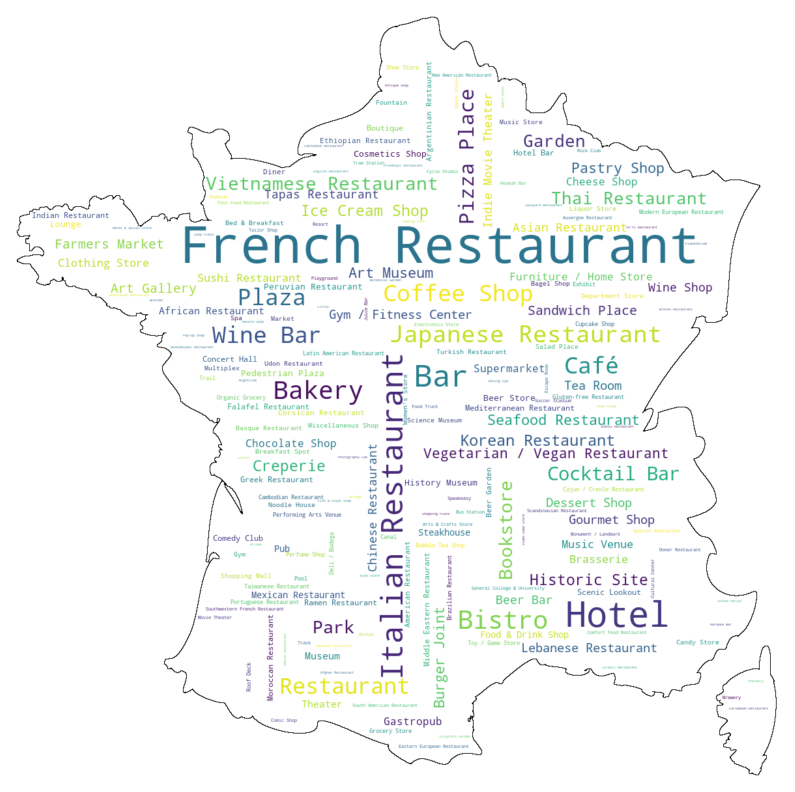

In [6]:
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

paris_mask = np.array(Image.open('francemap_binmask.png'))
'''fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height
plt.axis('off')
plt.imshow(paris_mask, cmap=plt.cm.gray, interpolation='bilinear')'''

wordcloud = WordCloud(background_color='white', mask=paris_mask, contour_width=1).generate_from_frequencies(collections.Counter(key_list))
plt.figure(figsize=(14,18))
plt.axis('off')
plt.imshow(wordcloud,interpolation='bilinear')


#### 3. Normalizing top values

In [7]:
# Normalizing values
top = lim
df = occurrences.iloc[:top, :]
tot = df["Paris"].sum()
dff_paris = df/tot

#Normalize
dff_paris = dff_paris/dff_paris.max()

print(dff_paris.shape)
dff_paris.head(20)

(100, 1)


,Paris
French Restaurant,1.000000
Hotel,0.379928
Bar,0.268817
Italian Restaurant,0.265233
Bistro,0.189964
Bakery,0.182796
Japanese Restaurant,0.164875
Wine Bar,0.157706
Plaza,0.154122
Coffee Shop,0.150538


Then we normalize the data to have a result between 0 et 1. The idea here is to attribute a weight to a data based on its occurences.

#### 4. Data analysis

In [64]:
dff_paris.describe()

,Paris
count,100.000000
mean,0.063728
std,0.112318
min,0.014337
25%,0.021505
50%,0.035842
75%,0.060932
max,1.000000


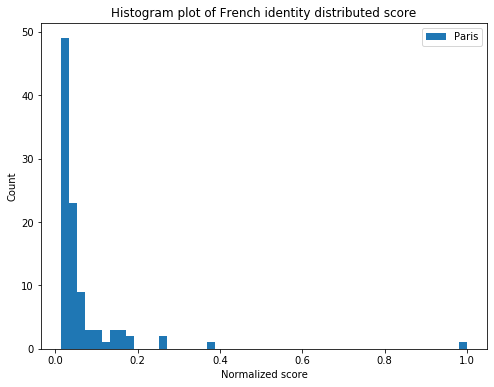

In [65]:
dff_paris.plot(kind='hist',bins=50, figsize=(8, 6))

plt.title('Histogram plot of French identity distributed score')
plt.ylabel('Count')
plt.xlabel('Normalized score')

plt.show()

### II. Exploring top popular venues in every Montreal boroughs

#### 1. List of Montreal boroughs and gps coordinates

In [10]:
import pandas as pd
link = "https://en.wikipedia.org/wiki/Boroughs_of_Montreal"

df_montreal = pd.read_html(link)
df_montreal = df_montreal[0]

# Drop unused column and rows + renaming data 
df_montreal.drop(['Number(map)','Population Canada 2016 Census[1]','Density per km²'], axis=1, inplace=True)
df_montreal.rename(columns={"Area in km²":"Area(km²)"},inplace=True)
df_montreal['Borough'] = df_montreal['Borough'].replace(['Côte-des-Neiges–Notre-Dame-de-Grâce',\
                                                         "L'Île-Bizard–Sainte-Geneviève",\
                                                         'Mercier–Hochelaga-Maisonneuve',\
                                                         'Montréal-Nord',\
                                                         'Rivière-des-Prairies–Pointe-aux-Trembles',\
                                                         'Rosemont–La Petite-Patrie',\
                                                         'Saint-Léonard',\
                                                         'Villeray–Saint-Michel–Parc-Extension'],
                                                        ['Cote-des-Neiges-Notre-Dame-de-Grace',\
                                                         "L'Ile-Bizard-Sainte-Genevieve",\
                                                         'Mercier-Hochelaga-Maisonneuve',\
                                                         'Montreal-Nord',\
                                                         'Riviere-des-Prairies-Pointe-aux-Trembles',\
                                                         'Rosemont-La Petite-Patrie',\
                                                         'Saint-Leonard',\
                                                         'Villeray-Saint-Michel-Parc-Extension'])
print("We rename the boroughs to avoid 'é', 'à', 'Î' : map visualization was not working because of those.")
            
df_montreal

We rename the boroughs to avoid 'é', 'à', 'Î' : map visualization was not working because of those.


,Borough,Area(km²)
0,Ahuntsic-Cartierville,24.2
1,Anjou,13.7
2,Cote-des-Neiges-Notre-Dame-de-Grace,21.4
3,Lachine,17.7
4,LaSalle,16.3
5,Le Plateau-Mont-Royal,8.1
6,Le Sud-Ouest,15.7
7,L'Ile-Bizard-Sainte-Genevieve,23.6
8,Mercier-Hochelaga-Maisonneuve,25.4
9,Montreal-Nord,11.1


In [11]:
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# We use geocoders to find the latitude and longitude of Montreal boroughs
latitude_list=[]
longitude_list=[]
for i in range(df_montreal.shape[0]):
        
    address = 'Montreal, ' + str(df_montreal.iloc[i,0])
    
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude_list.append(location.latitude)
    longitude_list.append(location.longitude)

geo_montreal = pd.DataFrame(list(zip(df_montreal['Borough'].tolist(),latitude_list, longitude_list)),columns =['Borough','Latitude', 'Longitude'])
df_montreal = pd.merge(geo_montreal, df_montreal, on="Borough")
df_montreal = df_montreal[['Borough', 'Latitude', 'Longitude','Area(km²)']]
df_montreal

,Borough,Latitude,Longitude,Area(km²)
0,Ahuntsic-Cartierville,45.541892,-73.680319,24.2
1,Anjou,45.604898,-73.546672,13.7
2,Cote-des-Neiges-Notre-Dame-de-Grace,45.483609,-73.626970,21.4
3,Lachine,45.448676,-73.711204,17.7
4,LaSalle,45.432514,-73.629267,16.3
5,Le Plateau-Mont-Royal,45.521836,-73.582173,8.1
6,Le Sud-Ouest,45.467991,-73.588561,15.7
7,L'Ile-Bizard-Sainte-Genevieve,45.495042,-73.903445,23.6
8,Mercier-Hochelaga-Maisonneuve,45.574099,-73.525838,25.4
9,Montreal-Nord,45.593899,-73.637606,11.1


#### 2. Explore popular venues for every Montreal borough

In [12]:
dict_list_top2 = {}
key_list2 = []
LIMIT_list = []
lim = 100

import math
for val in range(df_montreal.shape[0]):
    LIMIT = lim
    radius = 500*math.sqrt(float(df_montreal.loc[val,'Area(km²)']))
    #radius = 2000
    #radius depends on the area of the borough
    latitude = df_montreal.loc[val,'Latitude']
    longitude = df_montreal.loc[val,'Longitude']
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    #url = 'https://api.foursquare.com/v2/venues/trending?client_id={}&client_secret={}&ll={},{}&v={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION)
    
    import requests
    # send GET request and get trending venues
    results = requests.get(url).json()
    items = results['response']['groups'][0]['items']
    LIMIT = len(items)
    LIMIT_list.append(len(items))
    list_top2 = []
    
    for i in range(LIMIT_list[val]):
        fam = items[i]['venue']['categories'][0]['name']
        list_top2.append(fam)
        key_list2.append(fam)
    dict_list_top2.update({str(df_montreal.loc[val,'Borough']):list_top2})
        
print(LIMIT_list)
b = pd.json_normalize(dict_list_top2)
b

[100, 88, 100, 34, 86, 100, 100, 14, 98, 35, 84, 67, 33, 100, 100, 69, 87, 100, 100]


,Ahuntsic-Cartierville,Anjou,Cote-des-Neiges-Notre-Dame-de-Grace,Lachine,LaSalle,Le Plateau-Mont-Royal,Le Sud-Ouest,L'Ile-Bizard-Sainte-Genevieve,Mercier-Hochelaga-Maisonneuve,Montreal-Nord,Outremont,Pierrefonds-Roxboro,Riviere-des-Prairies-Pointe-aux-Trembles,Rosemont-La Petite-Patrie,Saint-Laurent,Saint-Leonard,Verdun,Ville-Marie,Villeray-Saint-Michel-Parc-Extension
0,"[Café, Wine Bar, Lounge, Bakery, Italian Resta...","[BBQ Joint, Restaurant, Ice Cream Shop, Shoppi...","[Vegetarian / Vegan Restaurant, Portuguese Res...","[Restaurant, Italian Restaurant, Dessert Shop,...","[Italian Restaurant, Coffee Shop, Italian Rest...","[Middle Eastern Restaurant, Bakery, Toy / Game...","[Brewery, Bar, Pub, Lounge, Pizza Place, Frenc...","[Park, Golf Course, Sandwich Place, Grocery St...","[Boxing Gym, Gym / Fitness Center, Go Kart Tra...","[Fast Food Restaurant, Pharmacy, Ice Cream Sho...","[Pizza Place, Park, Ice Cream Shop, Park, Ital...","[Ice Cream Shop, Island, Skating Rink, Breakfa...","[Breakfast Spot, Restaurant, Restaurant, Groce...","[Vietnamese Restaurant, Diner, Bakery, Brewery...","[Café, Hot Dog Joint, Gym, Italian Restaurant,...","[Sandwich Place, Thai Restaurant, Restaurant, ...","[Breakfast Spot, Cheese Shop, Tea Room, Grocer...","[Church, Café, Portuguese Restaurant, Men's St...","[Café, Park, Pool, Spanish Restaurant, Tapas R..."


Same as we did for Paris : here we have a top of the most popular places in every Montreal borough.

The line composed of [100, 88, ..., 100] is the number of popular venues for each borough.

The 100 limit was defined by lim and LIMIT in our foursquare research 'url', it defines the max number of venues we want.

The radius defines the radius of the circle (in meter) to explore the place around the GPS coordinates of a borough. To make in simplier we condsidered a borough as a square LxL dimension and L² area.

In [13]:
import collections
import itertools

# Exporting the number of hits and sorting data
key_list2 = sorted(key_list2, key=collections.Counter(key_list2).get, reverse=True)
occurrences2 = collections.Counter(key_list2)
occurrences2 = pd.json_normalize(occurrences2)
occurrences2 = occurrences2.transpose()
occurrences2.rename(columns={0: "Montreal"},inplace=True)

Let's see the Word cloud of Montreal top venues

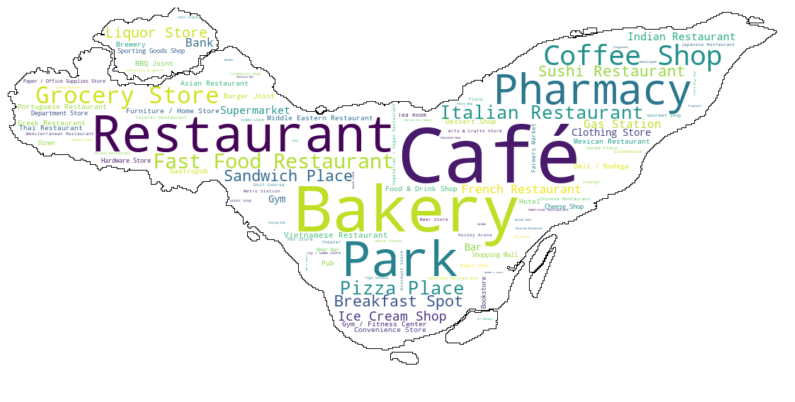

In [14]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

montreal_mask = np.array(Image.open('montreal_binmask.png'))
'''fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height
plt.axis('off')
plt.imshow(paris_mask, cmap=plt.cm.gray, interpolation='bilinear')'''

wordcloud2 = WordCloud(background_color='white', mask=montreal_mask, contour_width=1).generate_from_frequencies(collections.Counter(key_list2))
plt.figure(figsize=(14,18))
plt.axis('off')
plt.imshow(wordcloud2,interpolation='bilinear')


#### 3. Get and normalize the dataframes of popular venues in every borough

In [15]:
ar = pd.DataFrame({})
for bor in df_montreal['Borough']:
    oc = collections.Counter(dict_list_top2[bor])
    oc = pd.json_normalize(oc)   
    oc = oc.transpose()
    oc.rename(columns={0:bor}, inplace=True)
    ar = pd.concat([oc,ar])

print(LIMIT_list)
ar = ar.fillna(0)
ar = ar/(LIMIT_list[::-1])
ar = pd.concat([ar])
ar2 = ar.transpose()
ar2 = ar2.reset_index(drop=True)

#print(ar2)

ar["Cat"] = ar.index.values
ar = ar.reset_index(drop=True)
ar = ar.groupby(by="Cat").sum()
print(ar.shape)

# Normalized
ar = ar/ar.max().max()
ar.head(20)

[100, 88, 100, 34, 86, 100, 100, 14, 98, 35, 84, 67, 33, 100, 100, 69, 87, 100, 100]
(206, 19)


,Villeray-Saint-Michel-Parc-Extension,Ville-Marie,Verdun,Saint-Leonard,Saint-Laurent,Rosemont-La Petite-Patrie,Riviere-des-Prairies-Pointe-aux-Trembles,Pierrefonds-Roxboro,Outremont,Montreal-Nord,Mercier-Hochelaga-Maisonneuve,L'Ile-Bizard-Sainte-Genevieve,Le Sud-Ouest,Le Plateau-Mont-Royal,LaSalle,Lachine,Cote-des-Neiges-Notre-Dame-de-Grace,Anjou,Ahuntsic-Cartierville
Cat,,,,,,,,,,,,,,,,,,,
Accessories Store,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054264,0.000000,0.000000,0.000000,0.000000
American Restaurant,0.000000,0.000000,0.00000,0.000000,0.046667,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.054264,0.000000,0.000000,0.053030,0.000000
Art Gallery,0.046667,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046667,0.000000,0.000000,0.000000,0.046667,0.000000,0.000000
Art Museum,0.000000,0.093333,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Arts & Crafts Store,0.000000,0.000000,0.00000,0.067633,0.046667,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053030,0.046667
Arts & Entertainment,0.046667,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Asian Restaurant,0.046667,0.000000,0.00000,0.067633,0.000000,0.000000,0.000000,0.139303,0.055556,0.000000,0.000000,0.000000,0.140000,0.000000,0.054264,0.137255,0.046667,0.000000,0.093333
Athletics & Sports,0.000000,0.000000,0.00000,0.000000,0.046667,0.000000,0.000000,0.069652,0.000000,0.000000,0.047619,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Australian Restaurant,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046667,0.000000,0.000000,0.000000,0.000000,0.000000


We obtain our two matrix : the weighted from Paris and the weighted from Montreal.

#### 4. Data Analysis

In [66]:
ar.describe()

,Villeray-Saint-Michel-Parc-Extension,Ville-Marie,Verdun,Saint-Leonard,Saint-Laurent,Rosemont-La Petite-Patrie,Riviere-des-Prairies-Pointe-aux-Trembles,Pierrefonds-Roxboro,Outremont,Montreal-Nord,Mercier-Hochelaga-Maisonneuve,L'Ile-Bizard-Sainte-Genevieve,Le Sud-Ouest,Le Plateau-Mont-Royal,LaSalle,Lachine,Cote-des-Neiges-Notre-Dame-de-Grace,Anjou,Ahuntsic-Cartierville
count,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000
mean,0.022654,0.022654,0.022654,0.022654,0.022654,0.022654,0.022654,0.022654,0.022654,0.022654,0.022654,0.022654,0.022654,0.022654,0.022654,0.022654,0.022654,0.022654,0.022654
std,0.065468,0.052298,0.054323,0.060840,0.046031,0.056778,0.085941,0.059820,0.056728,0.081744,0.051672,0.106810,0.049800,0.057889,0.057987,0.087013,0.047171,0.057188,0.049587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.046667,0.000000,0.000000,0.046667,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.046667,0.046667,0.000000,0.000000,0.046667,0.000000,0.046667
max,0.700000,0.420000,0.375479,0.473430,0.280000,0.513333,0.565657,0.348259,0.500000,0.666667,0.333333,1.000000,0.326667,0.513333,0.434109,0.960784,0.280000,0.371212,0.326667


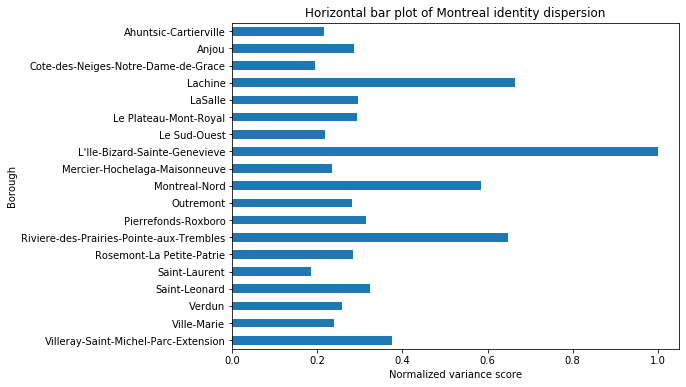

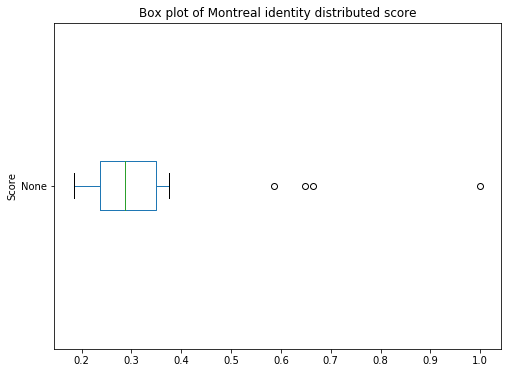

In [67]:
norar = ar.var()/ar.var().max()
norar.plot(kind='barh', stacked=False, figsize=(8, 6))
plt.title('Horizontal bar plot of Montreal identity dispersion')
plt.ylabel('Borough')
plt.xlabel('Normalized variance score')
plt.show()
norar.plot(kind='box', vert=False, figsize=(8,6))
plt.title('Box plot of Montreal identity distributed score')
plt.ylabel('Score')

plt.show()

### III. Building a model to match the Frenchest Montreal borough

#### 1. Cleaning our France and Montreal Data

First of all, the main idea would be to calculate the matrix product between our Parisian top venues with our Montreal top venues. The data are already weighted, based on the top venues categories occurences in each borough.
To do that we first need to check if our matrixes are well shaped.

In [28]:
dff_paris2 = dff_paris
ar2 = ar

In [29]:
dff2 = pd.DataFrame(ar.index.values, columns=['Cat'])
dff_paris2["Cat"] = dff_paris2.index.values
dff_paris2 = dff_paris2.append(dff2)
dff_paris2 = dff_paris2.fillna(0)
dff_paris2 = dff_paris2.groupby(by="Cat").sum()
print(dff_paris2.shape)
dff_paris2

(222, 1)


,Paris
Cat,
Accessories Store,0.000000
African Restaurant,0.032258
American Restaurant,0.017921
Argentinian Restaurant,0.017921
Art Gallery,0.050179
...,...
Wine Bar,0.157706
Wine Shop,0.043011
Women's Store,0.014337


In [30]:
dif = list(set(dff_paris2.index.values).difference(set(ar2.index.values)))
print(dif)
print((dff_paris2['Paris'].loc[dif]).sort_values(ascending=False))
print('Paris: ',dff_paris2.shape,'Montreal: ', ar2.shape)


['Basque Restaurant', 'Wine Shop', 'Argentinian Restaurant', 'Fountain', 'Noodle House', 'Ethiopian Restaurant', 'African Restaurant', 'Brasserie', 'History Museum', 'Pedestrian Plaza', 'Udon Restaurant', 'Moroccan Restaurant', 'Science Museum', 'Candy Store', 'Ramen Restaurant', 'Corsican Restaurant']
Cat
Wine Shop                 0.043011
Brasserie                 0.039427
African Restaurant        0.032258
Pedestrian Plaza          0.025090
History Museum            0.025090
Ramen Restaurant          0.021505
Moroccan Restaurant       0.021505
Corsican Restaurant       0.017921
Ethiopian Restaurant      0.017921
Argentinian Restaurant    0.017921
Candy Store               0.014337
Science Museum            0.014337
Udon Restaurant           0.014337
Noodle House              0.014337
Fountain                  0.014337
Basque Restaurant         0.014337
Name: Paris, dtype: float64
Paris:  (222, 1) Montreal:  (206, 19)


**We want our Paris matrix to be sized as our Montreal matrix.**

According to our dataset the oversize are the categories we can find in Paris but not in Montreal.

Obviously there are History Museum or Wine shop in Montreal but an explanation to these misfit categories could be either they are not part of the top trending places or there were reassigned to a similar category.

We reassigned them as well. For example Brasserie can be considered as a French Restaurant.

**We are reassigning some of the most obvious categories to existing categories. For the one I consider too different to be reassigned, I will drop them from our Paris database.**

In [31]:
#Labelisation des non-label
dff_paris2.rename({'Fountain':'Plaza'\
                   ,'Pedestrian Plaza':'Plaza'\
                   ,'Brasserie':'French Restaurant'\
                   #,'Creperie':'French Restaurant'\
                   #,"Women's Store":'Clothing Store'\
                   ,'Corsican Restaurant':'French Restaurant'\
                   ,'Science Museum':'Museum'\
                   #,'Monument / Landmark':'Historic Site'\
                   #,'Hostel':'Hotel'\
                   #,'Bed & Breakfast':'Hotel'\
                   #,'Multiplex':'Movie Theater'\
                   ,'Basque Restaurant':'French Restaurant'\
                   ,'Wine Shop':'Wine bar'\
                   ,'History Museum':'Museum'\
                  }, axis='index',inplace=True)

dff_paris2 = dff_paris2.groupby(by="Cat").sum()
dif = list(set(dff_paris2.index.values).difference(set(ar.index.values)))
dff_paris2.drop(dif, inplace=True)
dff_paris2

,Paris
Cat,
Accessories Store,0.000000
American Restaurant,0.017921
Art Gallery,0.050179
Art Museum,0.060932
Arts & Crafts Store,0.000000
...,...
Warehouse Store,0.000000
Wine Bar,0.157706
Women's Store,0.014337


In [32]:
# Normalized
dff_paris2 = dff_paris2/dff_paris2.max()

Our new database is now sized just as the Montreal one.
Let's take a look at its histogram.

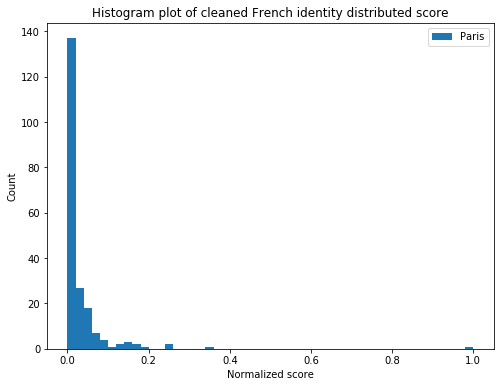

In [33]:
dff_paris2.plot(kind='hist',bins=50, figsize=(8, 6))

plt.title('Histogram plot of cleaned French identity distributed score')
plt.ylabel('Count')
plt.xlabel('Normalized score')

plt.show()

We can start building our models.

#### 2. French filtered Montreal matrix

We are now trying to find clusters in our database.
First we are multiplying the Paris Data to the Montreal Data to build our 'French-culture-weighted' Montreal database.

In [34]:
#Normalized
montreal_grouped_clustering = (ar2*dff_paris2.values).transpose()
montreal_grouped_clustering = montreal_grouped_clustering/montreal_grouped_clustering.max().max()
ser = montreal_grouped_clustering.transpose().var()/montreal_grouped_clustering.transpose().var().max()

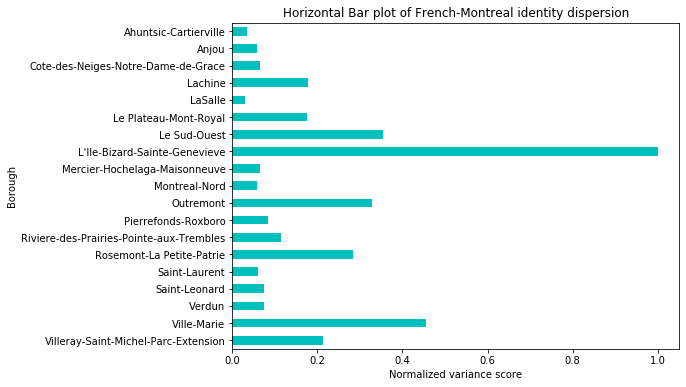

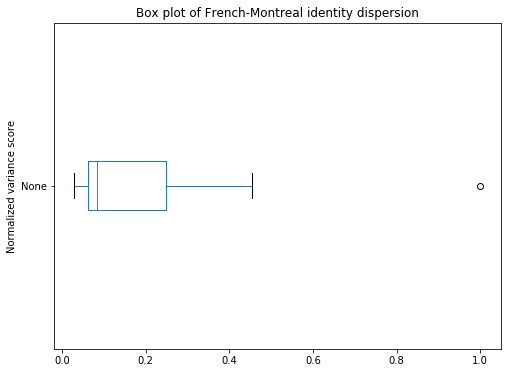

In [68]:
ser.plot(kind='barh', color='c' ,stacked=False, figsize=(8, 6))
plt.title('Horizontal Bar plot of French-Montreal identity dispersion')
plt.ylabel('Borough')
plt.xlabel('Normalized variance score')
plt.show()

ser.plot(kind='box', vert=False, figsize=(8,6))
plt.title('Box plot of French-Montreal identity dispersion')
plt.ylabel('Normalized variance score')
#plt.xlabel('Normalized variance score')
plt.show()

The bar plot represents the dispersion by borough of the new 'French-filtered' Montreal matrix. We can already sport some clusters.

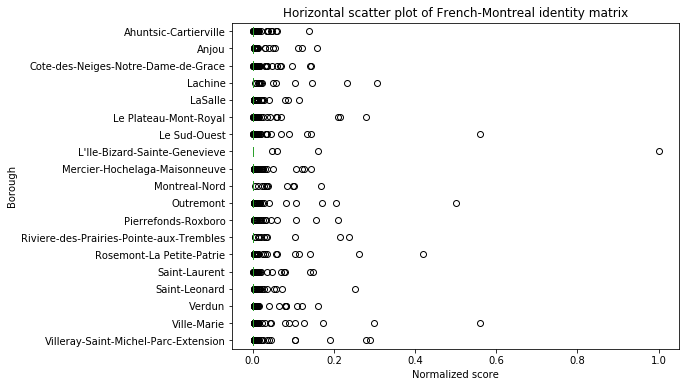

In [69]:
montreal_grouped_clustering.plot(kind='box',vert=False, figsize=(8, 6))

plt.title('Horizontal scatter plot of French-Montreal identity matrix')
plt.ylabel('Borough')
plt.xlabel('Normalized score')
plt.show()

Here is another way to visualize this new dataset.

#### 2. K-means Clustering

In [36]:
montreal_grouped_clustering = (ar2*dff_paris2.values)
# Normalized
montreal_grouped_clustering = montreal_grouped_clustering/montreal_grouped_clustering.max().max()

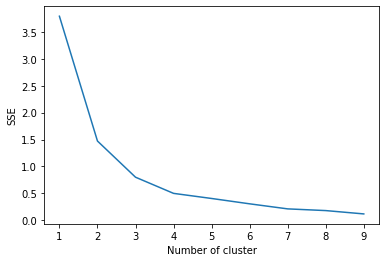

In [37]:
# Kmean model to find clusters
from sklearn.cluster import KMeans
sse = {}
for kclusters in range(1,10):
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(montreal_grouped_clustering)
    # check cluster labels generated for each row in the dataframe
    kmeans.labels_
    sse[kclusters] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Optimal K clusters can be found at the 'elbow' of the SSE graph. Here we can consider 2 clusters as the optimum K.

In [40]:
# set number of clusters
kclusters = 2
# run k-means clustering
kmeans2_model = KMeans(n_clusters=kclusters, random_state=0).fit(montreal_grouped_clustering.transpose())
df_montreal['Cluster Labels K=2'] = np.flip(kmeans2_model.labels_)


kclusters = 3
kmeans3_model = KMeans(n_clusters=kclusters, random_state=0).fit(montreal_grouped_clustering.transpose())
df_montreal['Cluster Labels K=3'] = np.flip(kmeans3_model.labels_)

df_montreal

,Borough,Latitude,Longitude,Area(km²),Cluster Labels K=2,Cluster Labels K=3
0,Ahuntsic-Cartierville,45.541892,-73.680319,24.2,1,1
1,Anjou,45.604898,-73.546672,13.7,1,1
2,Cote-des-Neiges-Notre-Dame-de-Grace,45.483609,-73.626970,21.4,1,1
3,Lachine,45.448676,-73.711204,17.7,1,1
4,LaSalle,45.432514,-73.629267,16.3,1,1
5,Le Plateau-Mont-Royal,45.521836,-73.582173,8.1,0,2
6,Le Sud-Ouest,45.467991,-73.588561,15.7,0,2
7,L'Ile-Bizard-Sainte-Genevieve,45.495042,-73.903445,23.6,0,0
8,Mercier-Hochelaga-Maisonneuve,45.574099,-73.525838,25.4,1,1
9,Montreal-Nord,45.593899,-73.637606,11.1,1,1


Then we visualize those clusters on a map.

In [41]:
# Cluster map
# create map
import folium 
import matplotlib.cm as cm
import matplotlib.colors as colors

latitude = 45.5016889
longitude = -73.567256
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=11)
kclusters = 2

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_montreal['Latitude'], df_montreal['Longitude'], df_montreal['Borough'], df_montreal['Cluster Labels K=2']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)


In [42]:
latitude = 45.5016889
longitude = -73.567256
map_clusters3 = folium.Map(location=[latitude, longitude], zoom_start=11)
kclusters = 3

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_montreal['Latitude'], df_montreal['Longitude'], df_montreal['Borough'], df_montreal['Cluster Labels K=3']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters3)

In [43]:
from IPython.core.display import display, HTML

htmlmap_clusters = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(map_clusters2.get_root().render().replace('"', '&quot;'),500,500,
                   map_clusters3.get_root().render().replace('"', '&quot;'),500,500))

# Montrealfim_map and Montrealfpop_map
display(htmlmap_clusters)

D:\ESPACE_DE_TRAVAIL\Anaconda\lib\site-packages\IPython\core\display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


**We can see two clusters : one in the east area of Montreal (and in L'Ile-Bizard-Sainte-Genevieve) plus another one in the rest of the boroughs.**
**'Zero' labeled cluster is the cluster containing a French influence. 'One' labeled are the ones containing a non-French influence**
**3 clusters model is showing an east coast and a west coast cluster.

#### 3. Content-based Recommender inspired by Netflix recommendation algorithms

Another way is to sum the values of French the filtered Montreal matrix.
The highest score is the best match to French culture and so to potential clusters of French people.

In [44]:
# match Matrix

res = (dff_paris2.transpose()).dot(ar2)
res = res.transpose()
res = res.sort_values(by=['Paris'], ascending=False)

res.reset_index(inplace=True)
res.rename(columns={"index":"Borough"},inplace=True)
# Normalized
res['Paris'] = (res['Paris']-res['Paris'].min()) / (res['Paris'].max()-res['Paris'].min())
res = pd.DataFrame(res)
res.transpose()




,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Borough,Ville-Marie,Rosemont-La Petite-Patrie,Outremont,Le Sud-Ouest,Villeray-Saint-Michel-Parc-Extension,L'Ile-Bizard-Sainte-Genevieve,Le Plateau-Mont-Royal,Lachine,Cote-des-Neiges-Notre-Dame-de-Grace,Verdun,Mercier-Hochelaga-Maisonneuve,Saint-Laurent,Pierrefonds-Roxboro,Riviere-des-Prairies-Pointe-aux-Trembles,Anjou,Saint-Leonard,Ahuntsic-Cartierville,Montreal-Nord,LaSalle
Paris,1,0.735258,0.712086,0.689626,0.662483,0.601566,0.545257,0.389341,0.349355,0.265516,0.251541,0.225048,0.191875,0.142201,0.129386,0.103329,0.0751715,0.0648875,0


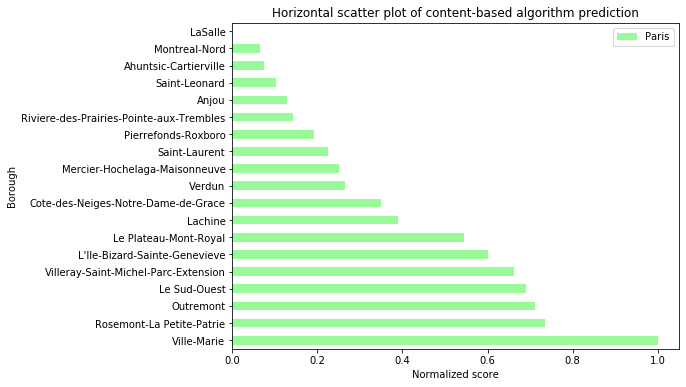

In [45]:
res_view = res.set_index('Borough')
res_view.plot(kind='barh',color = 'palegreen', figsize=(8, 6))

plt.title('Horizontal scatter plot of content-based algorithm prediction')
plt.ylabel('Borough')
plt.xlabel('Normalized score')
plt.show()

**Here our best match is "Ville-Marie" but we can see the top Frenchest Montreal boroughs are the ones on the east coast of Montreal. 
First we need to validate the models comparing it with census data.**

## Validation of the models/ Result section

### I. Map of Montreal : French immigrants by borough from official census reports

Source: http://ville.montreal.qc.ca/portal/page_pageid=6897.67845597&_dad=portal&_schema=PORTAL

In [46]:
#!pip install folium --upgrade
import folium

dfMtrl = pd.read_csv('French Immigration Montreal 2016.csv')
dfMtrl.drop(['Source: http://ville.montreal.qc.ca/portal/page?_pageid=6897.67845597&_dad=portal&_schema=PORTAL'], axis=1, inplace=True)
#url_geoMontreal = 'http://donnees.ville.montreal.qc.ca/dataset/00bd85eb-23aa-4669-8f1b-ba9a000e3dd8/resource/e9b0f927-8f75-458c-8fda-b5da65cc8b73/download/limadmin.json'
geoMontreal = r'geoMontreal.json'


# create a plain world map
dfMtrl = pd.DataFrame(dfMtrl)
# Normalized
#dfMtrl['% French immigrants / total borough immigrant (2016)'] = dfMtrl['% French immigrants / total borough immigrant (2016)']/dfMtrl['% French immigrants / total borough immigrant (2016)'].max()
#dfMtrl['% French immigrants / total borough population (2016)'] = dfMtrl['% French immigrants / total borough population (2016)']/dfMtrl['% French immigrants / total borough population (2016)'].max()
dfMtrl

,Borough,% French immigrants / total borough immigrant (2016),% French immigrants / total borough population (2016)
0,Ahuntsic-Cartierville,3.5,1.36
1,Anjou,2.8,0.90
2,Cote-des-Neiges-Notre-Dame-de-Grace,5.5,2.50
3,Lachine,4.8,1.03
4,LaSalle,1.5,0.53
5,Le Plateau-Mont-Royal,27.7,6.47
6,Le Sud-Ouest,8.2,2.01
7,L'Ile-Bizard-Sainte-Genevieve,5.2,1.27
8,Mercier-Hochelaga-Maisonneuve,9.6,1.96
9,Montreal-Nord,1.4,0.55


Here are the 2016 census reports counting the number of French people in every borough of Montreal.

I decided to take the proportion data (% French immigrants / total borough immigrant (2016)) and (% French immigrants / total borough population (2016)) because both give us a good idea of the influence of the French culture among others culture in a borough.

Indeed if a borough has a high rate of French on the total number of immigrants in this borough, we can suppose this borough will be mostly influenced by French culture and so we will most probably find French restaurant or Bakeries, for example.

In [47]:
Montrealfim_map = folium.Map(location=[45.5016889, -73.567256], zoom_start=10, tiles='Mapbox Bright')
# create a choropleth Montreal map for % French immigrants / total borough immigrant (2016)
Montrealfim_map.choropleth(
    geo_data=geoMontreal,
    data=dfMtrl,
    columns=['Borough', '% French immigrants / total borough immigrant (2016)'],
    key_on='feature.properties.NOM',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='% French immigrants / total borough immigrant (2016) in Montreal',
    threshold_scale=[1, 5, 10, 14, 19, 23, 28]
)






D:\ESPACE_DE_TRAVAIL\Anaconda\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [48]:
Montrealfpop_map = folium.Map(location=[45.5016889, -73.567256], zoom_start=10, tiles='Mapbox Bright')
# create a choropleth Montreal map for % French immigrants / total borough population (2016)
Montrealfpop_map.choropleth(
    geo_data=geoMontreal,
    data=dfMtrl,
    columns=['Borough', '% French immigrants / total borough population (2016)'],
    key_on='feature.properties.NOM',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='% French immigrants / total borough population (2016) in Montreal',
    #threshold_scale=[0.4, 1.4, 2.5, 3.5, 4.5, 5.5, 6.5]
)


In [49]:
from IPython.core.display import display, HTML

htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(Montrealfim_map.get_root().render().replace('"', '&quot;'),500,500,
                   Montrealfpop_map.get_root().render().replace('"', '&quot;'),500,500))

# Montrealfim_map and Montrealfpop_map
display(htmlmap)

D:\ESPACE_DE_TRAVAIL\Anaconda\lib\site-packages\IPython\core\display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


We can see French are most likely living in the east part of Montreal. This could be explained by the presence of the Francophone university of Montreal or The French ambassy for example.

### II. Map of Montreal : French immigrants by borough according to our model

Now we are going to compare our model with the % French immigrants / total borough immigrant (2016) census. This gives us a good idea of the weight of the French culture in those areas.

In [50]:
Montreal_model_map = folium.Map(location=[45.5016889, -73.567256], zoom_start=10, tiles='Mapbox Bright')
# create a choropleth Montreal map estimating the presence of Frenchies / borough (2020)
Montreal_model_map.choropleth(
    geo_data=geoMontreal,
    data=res,
    columns=['Borough', 'Paris'],
    key_on='feature.properties.NOM',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Model prediction of French immigrants (2020)'
    ,threshold_scale=[0,0.31,0.5,0.7,0.8,0.9,1]#,threshold_scale=[0.006,0.010,0.013,0.015,0.017,0.019,0.022]#,threshold_scale=[0.006,0.012,0.017,0.021,0.023,0.025,0.027]#,threshold_scale=[0,0.09,0.18,0.24,0.3,0.36,0.42,0.54]#,threshold_scale=[0.002, 0.012, 0.018, 0.029, 0.038, 0.046, 0.056]
)

In [51]:
htmlmap2 = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(Montrealfim_map.get_root().render().replace('"', '&quot;'),500,500,
                   Montreal_model_map.get_root().render().replace('"', '&quot;'),500,500))

# Montrealfim_map and Montreal_model_map
display(htmlmap2)

First of all we notice 2 things :

* Our model gives us a good idea of the presence of French people in Montreal : The East coast and the west area are well represented. 
* The proportion between boroughs are not alway respected.

Let's try to know a bit more about this prediction calcuating the error of borough ranking.

#### RMSE ranking calcul
A way to evaluate this model would be to calcute the RMSE of the borough ranking of the model VS borough ranking of the census.

In [52]:
census_ranking = dfMtrl[['Borough','% French immigrants / total borough immigrant (2016)']]
census_ranking['Census rank'] = census_ranking['% French immigrants / total borough immigrant (2016)'].rank()
census_ranking.sort_values(by='Census rank', ascending = True)

model_ranking = res[['Borough', 'Paris']]
model_ranking['Model rank'] = model_ranking['Paris'].rank()
model_ranking.sort_values(by='Model rank', ascending = True)

rmse_mat = pd.concat([census_ranking,model_ranking])
rmse_mat = rmse_mat.groupby(by='Borough').sum()
rmse_mat.drop(columns=['% French immigrants / total borough immigrant (2016)','Paris'], inplace=True)
rmse_mat

,Census rank,Model rank
Borough,,
Ahuntsic-Cartierville,8.0,3.0
Anjou,7.0,5.0
Cote-des-Neiges-Notre-Dame-de-Grace,12.0,11.0
L'Ile-Bizard-Sainte-Genevieve,11.0,14.0
LaSalle,4.0,1.0
Lachine,10.0,12.0
Le Plateau-Mont-Royal,19.0,13.0
Le Sud-Ouest,13.0,16.0
Mercier-Hochelaga-Maisonneuve,14.0,9.0


In [53]:
sum = 0
for cr,mr in zip(rmse_mat['Census rank'],rmse_mat['Model rank']):
    se = (mr-cr)**2
    sum = sum+se
rmse = math.sqrt(sum/19)

ymaxmin = rmse_mat['Census rank'].max()-rmse_mat['Census rank'].min()
print('Root-mean-squared-error =',rmse, 'Normalized Root-mean-squared-error =',rmse/ymaxmin)

Root-mean-squared-error = 3.4981197957278645 Normalized Root-mean-squared-error = 0.19433998865154803


RMSE = 3.66; It represents around 19% of error in the sorted ranking. We can try to optimize this ranking the model bouroughs and the census borough by clusters : That way we would detect 'group of borough' and not specific borough.

### III. Clustering Data and quantifying model

#### 1. French moel from Kmeans applied to French people census choropleth map

In [54]:
for lat, lon, poi, cluster in zip(df_montreal['Latitude'], df_montreal['Longitude'], df_montreal['Borough'], df_montreal['Cluster Labels K=2']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(Montrealfim_map)
Montrealfim_map

#### 2. Optimizing binary value for Choropleth map and quantifying results

In [55]:
dfMtrl_clus = dfMtrl    
#dfMtrl_clus
#rslt_df = dataframe.loc[dataframe['Percentage'] > 80]
for i in range(0,28):
    dfMtrl_clus[str(i)+'%cluster K=2'] = np.where(dfMtrl_clus['% French immigrants / total borough immigrant (2016)']>i, False, True)
    dfMtrl_clus[str(i)+'%cluster K=2'] = dfMtrl_clus[str(i)+'%cluster K=2'].astype(int)

train = dfMtrl_clus.iloc[:,3:]
test = pd.DataFrame(df_montreal['Cluster Labels K=2'])

tptn = train * test.values
fpfn = train - test.values



FN = fpfn[fpfn==-1].sum()*-1
FP = fpfn[fpfn==1].sum()
TN = tptn[tptn==1].sum()
TP = 19 - FN - FP - TN
conf = pd.concat([FN, FP, TN, TP], axis=1)
conf.columns = ['FN','FP','TN','TP']


conf['F-1 score'] = 2*conf['TP'] / (2*conf['TP']+conf['FP']+conf['FN'])
conf['Jaccard score'] = (conf['FP']+conf['FN']) / (conf['TP']+conf['FP']+conf['FN'])
conf['Specificity'] = conf['TN']/(conf['TN']+conf['FP'])
conf['Sensitivity'] = conf['TP']/(conf['TP']+conf['FN'])
conf['Accuracy'] = (conf['TP']+conf['TN']) / (conf['TP']+conf['FP']+conf['FN']+conf['TN'])
conf['1-Specificity'] = conf['FP']/(conf['TN']+conf['FP'])
conf['RMSE'] = (conf['FP']+conf['FN'])/(conf['TP']+conf['FP']+conf['FN']+conf['TN'])
conf

,FN,FP,TN,TP,F-1 score,Jaccard score,Specificity,Sensitivity,Accuracy,1-Specificity,RMSE
0%cluster K=2,12.0,0.0,0.0,7.0,0.538462,0.631579,NaN,0.368421,0.368421,NaN,0.631579
1%cluster K=2,12.0,0.0,0.0,7.0,0.538462,0.631579,NaN,0.368421,0.368421,NaN,0.631579
2%cluster K=2,6.0,0.0,6.0,7.0,0.700000,0.461538,1.000000,0.538462,0.684211,0.000000,0.315789
3%cluster K=2,5.0,0.0,7.0,7.0,0.736842,0.416667,1.000000,0.583333,0.736842,0.000000,0.263158
4%cluster K=2,4.0,0.0,8.0,7.0,0.777778,0.363636,1.000000,0.636364,0.789474,0.000000,0.210526
5%cluster K=2,3.0,1.0,9.0,6.0,0.750000,0.400000,0.900000,0.666667,0.789474,0.100000,0.210526
6%cluster K=2,2.0,2.0,10.0,5.0,0.714286,0.444444,0.833333,0.714286,0.789474,0.166667,0.210526
7%cluster K=2,2.0,2.0,10.0,5.0,0.714286,0.444444,0.833333,0.714286,0.789474,0.166667,0.210526
8%cluster K=2,2.0,2.0,10.0,5.0,0.714286,0.444444,0.833333,0.714286,0.789474,0.166667,0.210526
9%cluster K=2,2.0,3.0,10.0,4.0,0.615385,0.555556,0.769231,0.666667,0.736842,0.230769,0.263158


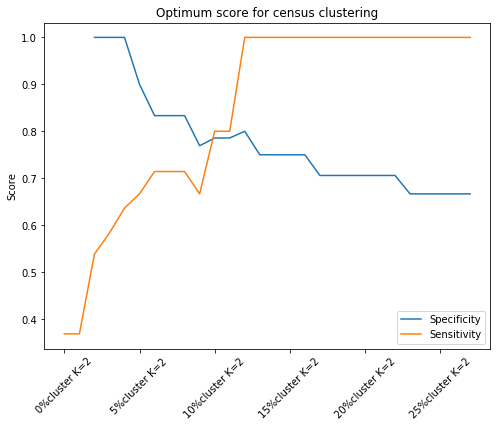

In [56]:
conf[["Specificity",'Sensitivity']].plot(kind='line', figsize=(8, 6))

plt.title('Optimum score for census clustering')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

The optimal value is at 12%. So we consider a French cluster significant if at least 12% of the total borough immigrant population is French.

That way we can cluster our choropleth map. 

In [57]:
Montrealfim_map = folium.Map(location=[45.5016889, -73.567256], zoom_start=10, tiles='Mapbox Bright')
# create a choropleth Montreal map for % French immigrants / total borough immigrant (2016)
Montrealfim_map.choropleth(
    geo_data=geoMontreal,
    data=dfMtrl,
    columns=['Borough', '% French immigrants / total borough immigrant (2016)'],
    key_on='feature.properties.NOM',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='% French immigrants / total borough immigrant (2016) in Montreal',
    threshold_scale=[0,11.998,11.999, 12, 28]
)

for lat, lon, poi, cluster in zip(df_montreal['Latitude'], df_montreal['Longitude'], df_montreal['Borough'], df_montreal['Cluster Labels K=2']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(Montrealfim_map)
Montrealfim_map

D:\ESPACE_DE_TRAVAIL\Anaconda\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [58]:
pd.DataFrame(conf.loc['12%cluster K=2'])

,12%cluster K=2
FN,-0.000000
FP,3.000000
TN,12.000000
TP,4.000000
F-1 score,0.727273
Jaccard score,0.428571
Specificity,0.800000
Sensitivity,1.000000
Accuracy,0.842105
1-Specificity,0.200000


## Results Section

#### 1. East coast cluster : Le Plateau-Mont-Royal and Ville-Marie.

Le Plateau-Mont-Royal is the borough with the biggest rate of French people (6.47% of total borough pop. and 27.7% of total borough immigrant) according to the 2016 census. But it is only ranked at the 6th position according to our model.
Let's take a look at it.

In [59]:
top = 12

top_PR = ar['Le Plateau-Mont-Royal']
top_PR = top_PR[top_PR>0].sort_values(ascending=False).head(top)
top_Paris = dff_paris2['Paris']
top_Paris = top_Paris[top_Paris>0].sort_values(ascending=False).head(top)

set1 = set(top_Paris.index.values)
common_elements = set1.intersection(top_PR.index.values)
print("Here are the main categories our Paris matrix and the borough Matrix have in common :\n",common_elements,"\n")
tpa = top_Paris.loc[list(common_elements)]
tpr = top_PR.loc[list(common_elements)]
t = (tpa*tpr).sum()
print(top,"of 100 top venues explains ", 100*t/res.iloc[5][1],"% of its score from the matching matrix.\n")
print("The top venues sorted in descending order are the following : \n",ar['Le Plateau-Mont-Royal'].sort_values(ascending=False).head(12))


Here are the main categories our Paris matrix and the borough Matrix have in common :
 {'Bakery', 'Japanese Restaurant', 'Coffee Shop', 'Café', 'Restaurant', 'French Restaurant'} 

12 of 100 top venues explains  46.75276910918697 % of its score from the matching matrix.

The top venues sorted in descending order are the following : 
 Cat
Café                             0.513333
Bakery                           0.420000
Portuguese Restaurant            0.233333
Park                             0.233333
Coffee Shop                      0.140000
Breakfast Spot                   0.140000
Ice Cream Shop                   0.140000
Restaurant                       0.093333
Japanese Restaurant              0.093333
Beer Bar                         0.093333
Vegetarian / Vegan Restaurant    0.093333
Men's Store                      0.093333
Name: Le Plateau-Mont-Royal, dtype: float64


***
La Ville-Marie is the borough with the most influenced by French culture (1st ranking in the matching matrix) according to our model. But it is only ranked at the 4th position according to our model. Let's take a look at it.

In [60]:
top = 12

top_PR = ar['Ville-Marie']
top_PR = top_PR[top_PR>0].sort_values(ascending=False).head(top)
top_Paris = dff_paris2['Paris']
top_Paris = top_Paris[top_Paris>0].sort_values(ascending=False).head(top)

set1 = set(top_Paris.index.values)
common_elements = set1.intersection(top_PR.index.values)
print("Here are the main categories our Paris matrix and the borough Matrix have in common :\n",common_elements,"\n")
tpa = top_Paris.loc[list(common_elements)]
tpr = top_PR.loc[list(common_elements)]
t = (tpa*tpr).sum()
print(top,"of 100 top venues explains ", 100*t/res.iloc[0][1],"% of its score from the matching matrix.\n")
print("The top venues sorted in descending order are the following : \n",ar['Ville-Marie'].sort_values(ascending=False).head(12))

Here are the main categories our Paris matrix and the borough Matrix have in common :
 {'Plaza', 'Hotel', 'Italian Restaurant', 'Japanese Restaurant', 'Coffee Shop', 'Café', 'Restaurant', 'French Restaurant'} 

12 of 100 top venues explains  49.054626532887404 % of its score from the matching matrix.

The top venues sorted in descending order are the following : 
 Cat
Café                  0.420000
Hotel                 0.280000
Plaza                 0.233333
Restaurant            0.233333
Park                  0.186667
Coffee Shop           0.186667
French Restaurant     0.186667
Italian Restaurant    0.140000
Grocery Store         0.093333
Salad Place           0.093333
Pizza Place           0.093333
Church                0.093333
Name: Ville-Marie, dtype: float64


***
East Cluster top venues

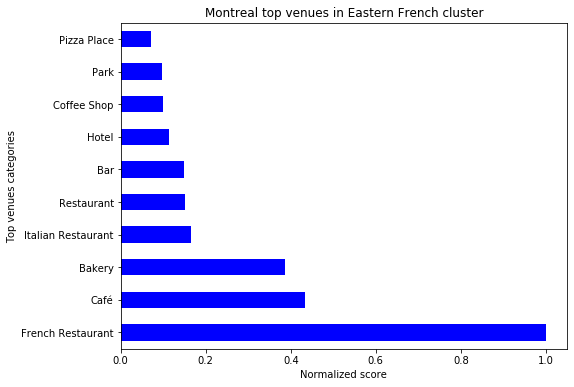

{'Bakery',
 'Bar',
 'Café',
 'Coffee Shop',
 'French Restaurant',
 'Hotel',
 'Italian Restaurant',
 'Restaurant'}

In [61]:
montreal_group = montreal_grouped_clustering.transpose()#.sort_values(by='Cat')
montreal_label = df_montreal[['Borough','Cluster Labels K=2']].sort_values(by='Borough',ascending=False)

bor = montreal_group.index.values
montreal_group.reset_index(inplace=True)
montreal_group.rename(columns={'index':'Borough'}, inplace=True)


montreal_grouplabel = pd.concat([montreal_group,montreal_label])
montreal_grouplabel = montreal_grouplabel.groupby(by='Borough').sum()
montreal_grouplabelEast = montreal_grouplabel.drop(montreal_grouplabel.index[3])
montreal_grouplabelEast = montreal_grouplabelEast.groupby(by='Cluster Labels K=2').sum()
montreal_grouplabelEast = montreal_grouplabelEast.drop(montreal_grouplabelEast.index[1])
montreal_grouplabelEast = montreal_grouplabelEast.transpose()
#montreal_grouplabelEast = montreal_grouplabelEast.drop(montreal_grouplabelEast.columns[1])#.sort_values(by=montreal_grouplabelEast.index[1],ascending=False)
montreal_grouplabelEast = montreal_grouplabelEast.sort_values(by=0.0, ascending = False)
montreal_grouplabelEast= (montreal_grouplabelEast/montreal_grouplabelEast.max()).head(10)



montreal_grouplabelEast.plot(kind='barh', color='b', legend=False, figsize=(8, 6), rot=0)
plt.title('Montreal top venues in Eastern French cluster')
plt.xlabel('Normalized score')
plt.ylabel('Top venues categories') 
plt.show()

set2 = set(top_Paris.index.values)
common_elements = set2.intersection(montreal_grouplabelEast[0.0].index.values)
common_elements

***
We can see both boroughs are influenced by the same kind of venues categories : the boroughs are actually very close to each other. And so the calcul method of top venues which is based on a circle area from the center of each borough, may have been influenced by neighborhoods.

#### 2. West side cluster : L'Ile-Bizard-Sainte-Genevieve.

L'Ile-Bizard-Sainte-Genevieve has a special status. Our 2 clusters k-means model classified it in the "under French influence" area though it is ranked 7th in our model and 9th in the census report.
Let's take a look at it.

In [62]:
top = 20

top_PR = ar["L'Ile-Bizard-Sainte-Genevieve"]
top_PR = top_PR[top_PR>0].sort_values(ascending=False).head(top)
top_Paris = dff_paris2['Paris']
top_Paris = top_Paris[top_Paris>0].sort_values(ascending=False).head(top)

set1 = set(top_Paris.index.values)
common_elements = set1.intersection(top_PR.index.values)
print(common_elements)
tpa = top_Paris.loc[list(common_elements)]
tpr = top_PR.loc[list(common_elements)]
t = (tpa*tpr).sum()
print(top,"of 16 top venues explains ", 100*t/res.iloc[6][1],"% of its score from the matching matrix.\n")
print("The top venues sorted in descending order are the following : \n",ar["L'Ile-Bizard-Sainte-Genevieve"].sort_values(ascending=False).head(20), "\n")
print("Top 3 borough for French restaurant :\n",ar.loc['French Restaurant'].sort_values(ascending=False).head(3))

{'Park', 'French Restaurant'}
20 of 16 top venues explains  70.94733602087454 % of its score from the matching matrix.

The top venues sorted in descending order are the following : 
 Cat
Golf Course            1.000000
Park                   0.666667
Sandwich Place         0.333333
Hockey Arena           0.333333
Gas Station            0.333333
Ice Cream Shop         0.333333
Convenience Store      0.333333
Pharmacy               0.333333
Athletics & Sports     0.333333
Grocery Store          0.333333
French Restaurant      0.333333
Dumpling Restaurant    0.000000
Drugstore              0.000000
Zoo                    0.000000
Electronics Store      0.000000
Donut Shop             0.000000
Escape Room            0.000000
Event Space            0.000000
English Restaurant     0.000000
Dog Run                0.000000
Name: L'Ile-Bizard-Sainte-Genevieve, dtype: float64 

Top 3 borough for French restaurant :
 L'Ile-Bizard-Sainte-Genevieve    0.333333
Ville-Marie                      0.18

***
First we noticed L'Ile-Bizard-Sainte-Genevieve has only 11 top venues categories. It means it contains a small amount of data, but well weighted regarding to our data preprocessing method.
It means a match with the French matrix can significantly improve its score, and that is what happened with the 1st rank of L'Ile-Bizard-Sainte-Genevieve in the French Restaurant Categories.

This borough area is wide but it mostly contains golf course and park : housing is along the coast and not well populated which explain the few number of venues. 

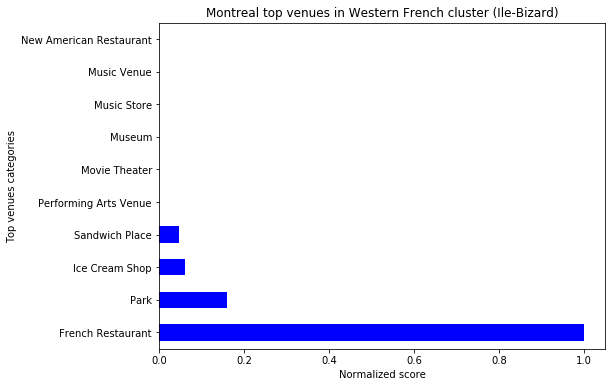

{'French Restaurant', 'Museum', 'Park'}

In [63]:
montreal_grouplabelWest = pd.DataFrame(montreal_grouplabel.loc[montreal_grouplabel.index[3]])
montreal_grouplabelWest = montreal_grouplabelWest.sort_values(by=montreal_grouplabelWest.columns[0], ascending = False).head(10)
"""montreal_grouplabelWest = montreal_grouplabelEast.sort_values(by=0.0, ascending = False)
montreal_grouplabelWest= (montreal_grouplabelEast/montreal_grouplabelEast.max()).head(20)"""

montreal_grouplabelWest.plot(kind='barh', color='b', legend=False, figsize=(8, 6), rot=0)
plt.title('Montreal top venues in Western French cluster (Ile-Bizard)')
plt.xlabel('Normalized score')
plt.ylabel('Top venues categories') 
plt.show()

set2 = set(top_Paris.index.values)
common_elements = set2.intersection(montreal_grouplabelWest.index.values)
common_elements

## Discussion section

We can see the model is giving :
* An good estimate of the living zone of French people (East part of Montreal).
* Some proportions miscalculation like L'Ile-Bizard-Sainte-Genevieve.

### I. A good idea of the living zone of French people.

Indeed we can see first that most places hardly inhabited by French people are not showing either in our model. The Choropleth map shows a good estimate of these low-rate zones even if the sensitivity of the model looks higher.

The K-means clustering model is giving us 2 or 3 interesting clusters, mainly because the French populated cluster contains many neighborhoods closed to each other. It corroborates the concept of immigrants population to tend to live geographicaly close to each others.

Finally the main trend of French influence in Montreal is clearly set to East Montreal and we can validate this trend thanks to the 2016 official census data.


But some paramters should be carefully considered. The east part of Montreal is the most densely populated part of Montreal. Our model, based on Paris top venues, is a very dense city as well. So that may explain why we found the same kind of trending places.

### II. Some misestimation like L'Ile-Bizard-Sainte-Genevieve.

Then we can discuss the cases of Pierrefonds-Roxboro and Le Plateau-Mont-Royal.

* **L'Ile-Bizard-Sainte-Genevieve is commonly called as a False Positive.**

Thanks to our previous calculous, we can see that the strong point of this borough is it contains very few top venues categories. Meaning his categories matrix is highy weighted and so any match with the French matrix increases drastically its matching score. That is how L'Ile-Bizard score the maximum weight for French retaurant : it may not contained many of these but there are part of the top venues of the island.

First explanation could be the town landscape of this region. It is an wide island not that much developed, excpet for the towns along the coast. Meaning the borough is not a dense place and so the top venues are quite limited.

Second explanation could be the way to search top venues in a borough : we search in a circle direction from the middle of the borough, with a given radius that is the rootsquare of the area of the borough.
As stated before **the borough of L'Ile-Bizard-Sainte-Genevieve is vast area with the main towns along the east coast of the island which could lead to a miscalculation of the top venues from this borough only.** The algorithm may not include the totality of those towns in the top venues reasearch.

***
To improve our model, We may optimize our top venues research searching at different places of a borough with a smaller radius.
In that way we would :
* 1. Increase the dataset for a borough and so give it a better identity.
* 2. Search in smaller areas contained in the borough so we would avoid to 'steal' top venues from close borough.


## Conclusion

Every country has his own culture. Defining a trend based on people culture sounds possible and quite interesting.
We first start stated someone living abroad will tend to live in a place the closest to his initial culture and will tend to live close to people from his home country.

My model gives us a good idea of clusters of French people using a low sized database and simple cluster algorithms.
But we can improve our results :
* We define our French model only on the city of Paris which represent only 3.1% of the total population in France which can not give us a good idea of what is the French culture.
* It may work better using a bigger dataset and changing the way to weight data.
* Canada is a democratic and cosmopolitan country. The system may not work as good in others country with a different immigrant policy.

I need to validate the model to make sure it is working good. The next steps would be to test it with others cities and others cultures.


